In [31]:
import yfinance as yf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



In [32]:
stocks = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'BABA', 'NOW', 'ADBE',
    'CRM', 'V', 'KO', 'PFE', 'PEP', 'INTC', 'CSCO', 'IBM', 'NFLX', 'ORCL'
]

# historical data for this time period
start_period = '2018-01-01'
end_period = '2022-12-31'

In [33]:
# making a folder that is meant to keep stock datasets incase there isnt one already made.
def create_folder():
    if not os.path.exists('Stocks'):
        os.makedirs('Stocks')

# the function meant for downloading and storing each dataset of the 20 stocks
def download_stock_dataset(stock):
    try:
        data = yf.download(stock, start=start_period, end=end_period, progress=False)
        data.to_csv(f'Stocks/{stock}.csv')
    except Exception as e:
        print(f'logging for errors for the stock {stock}: {e}')

# function to calculate monthly returns from daily stock prices
def calculate_monthly_returns(stock):
    try:
        # Load the stock data from CSV
        data = pd.read_csv(f'Stocks/{stock}.csv', parse_dates=['Date'], index_col='Date')
        # Calculate monthly returns
        monthly_returns = data['Adj Close'].resample('ME').ffill().pct_change()
        # Save the monthly returns to a new CSV file
        monthly_returns.to_csv(f'Stocks/{stock}_monthly_returns.csv', header=['Monthly Return'])
        return monthly_returns
    except Exception as e:
        print(f'Error calculating monthly returns for {stock}: {e}')
        return None

# Function to calculate the covariance matrix of monthly returns for all stocks
def calculate_covariance_matrix():
    try:
        monthly_returns_data = pd.DataFrame()
        for stock in stocks:
            # Load the monthly returns for each stock
            data = pd.read_csv(f'Stocks/{stock}_monthly_returns.csv', parse_dates=['Date'], index_col='Date')
            monthly_returns_data[stock] = data['Monthly Return']
        
        # Calculate covariance matrix
        covariance_matrix = monthly_returns_data.cov()
        # Save the covariance matrix to a CSV file
        covariance_matrix.to_csv('Stocks/covariance_matrix.csv')
        print('Covariance matrix has been calculated and saved.')

        # Plot the covariance matrix
        plt.figure(figsize=(15, 10))
        plt.imshow(covariance_matrix, cmap='coolwarm', interpolation='none')
        plt.colorbar()
        plt.xticks(range(len(stocks)), stocks, rotation=90)
        plt.yticks(range(len(stocks)), stocks)
        plt.title('Covariance Matrix of Monthly Returns')
        plt.tight_layout()
        plt.savefig('Stocks/covariance_matrix_plot.png')
        plt.show()
    except Exception as e:
        print(f'Error calculating covariance matrix: {e}')

# Function to plot monthly returns for each stock
def plot_monthly_returns():
    try:
        plt.figure(figsize=(15, 10))
        for stock in stocks:
            # Load the monthly returns for each stock
            data = pd.read_csv(f'Stocks/{stock}_monthly_returns.csv', parse_dates=['Date'], index_col='Date')
            plt.plot(data.index, data['Monthly Return'], label=stock)
        
        plt.xlabel('Date')
        plt.ylabel('Monthly Return')
        plt.title('Monthly Returns of Stocks')
        plt.legend()
        plt.tight_layout()
        plt.savefig('Stocks/monthly_returns_plot.png')
        plt.show()
    except Exception as e:
        print(f'Error plotting monthly returns: {e}')

def main():
    create_folder()
    # downloading stock datasets and storing them as CSV
    for stock in stocks:
        download_stock_dataset(stock)
    print('All datasets have been downloaded successfully.')

    # calculating monthly returns for each stock
    for stock in stocks:
        calculate_monthly_returns(stock)
    print('Monthly returns have been calculated for all stocks.')

# starting
if __name__ == "__main__":
    main()


All datasets have been downloaded successfully.
Monthly returns have been calculated for all stocks.


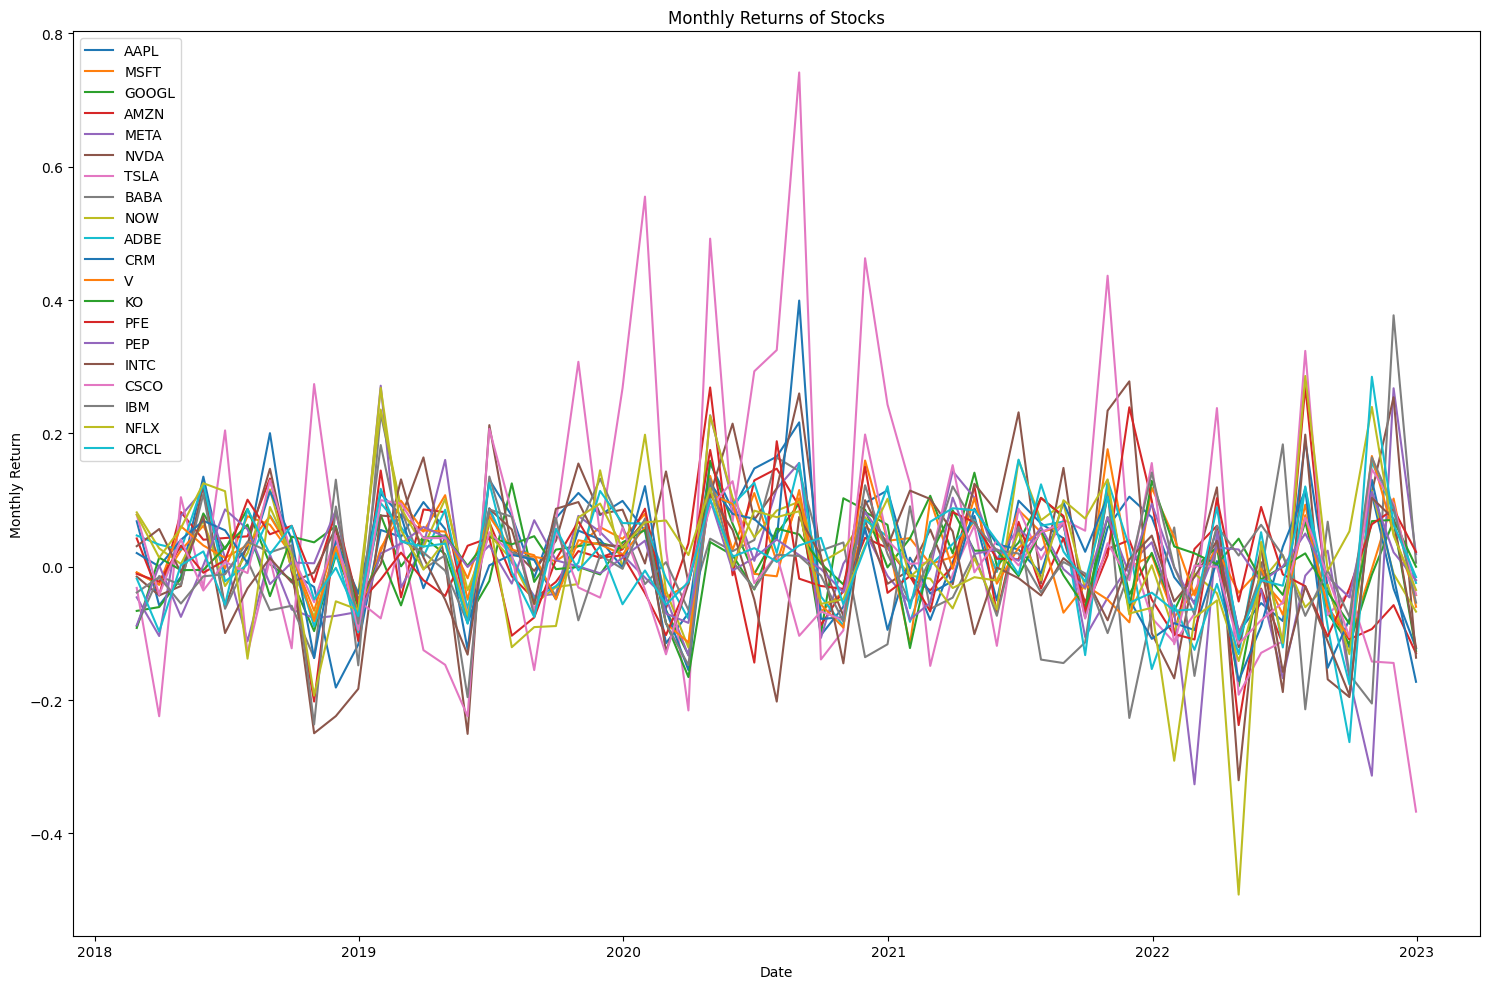

Covariance matrix has been calculated and saved.


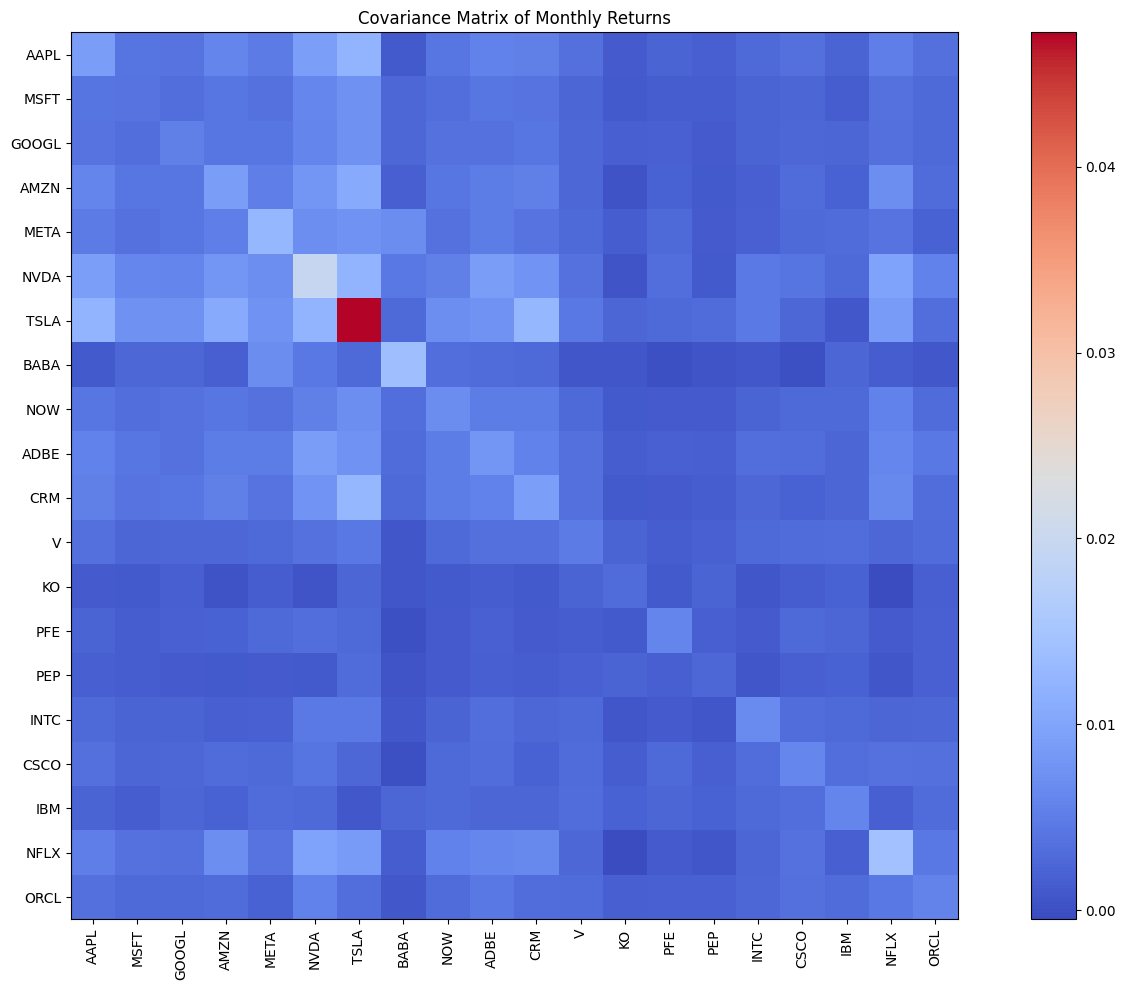

In [34]:

plot_monthly_returns()
calculate_covariance_matrix()
